## Lesson 1

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [2]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
    print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [3]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end = " ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [4]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end = " ")
    print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [5]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [6]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [7]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size = 10)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[2 3 4 5] [6]
[5 6 7 8] [9]
[0 1 2 3] [4]
[4 5 6 7] [8]
[1 2 3 4] [5]
[3 4 5 6] [7]


In [8]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size = 10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[4 5 6 7]
 [5 6 7 8]]
y =  [[8]
 [9]]
x =  [[3 4 5 6]
 [0 1 2 3]]
y =  [[7]
 [4]]
x =  [[1 2 3 4]
 [2 3 4 5]]
y =  [[5]
 [6]]


## Lesson 2

In [9]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss = "mse", 
              optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))
model.fit(dataset,epochs = 100,verbose = 0)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.03714076],
       [-0.09108914],
       [ 0.13504268],
       [ 0.0329551 ],
       [-0.05903871],
       [-0.01248899],
       [ 0.11115345],
       [-0.06798734],
       [-0.0990695 ],
       [ 0.05834108],
       [ 0.03350935],
       [-0.02050359],
       [-0.04421086],
       [ 0.08732148],
       [ 0.0190855 ],
       [ 0.00896822],
       [-0.02498974],
       [ 0.2214365 ],
       [ 0.3152303 ],
       [ 0.4091724 ]], dtype=float32), array([0.0147396], dtype=float32)]


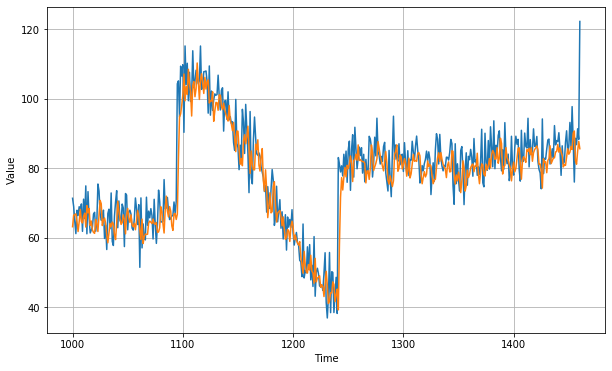

In [12]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.17107

## Lesson 3

In [14]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"), 
    tf.keras.layers.Dense(10, activation = "relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))
model.fit(dataset,epochs = 100,verbose = 0)

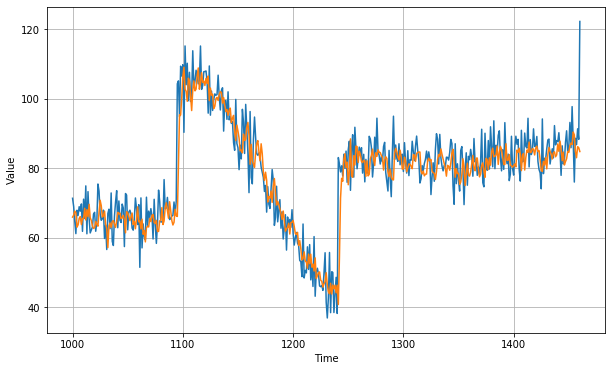

In [15]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9935718

In [17]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"), 
    tf.keras.layers.Dense(10, activation = "relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = "mse", optimizer = optimizer)
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule], verbose = 0)

[1e-08, 0.001, 0, 300]

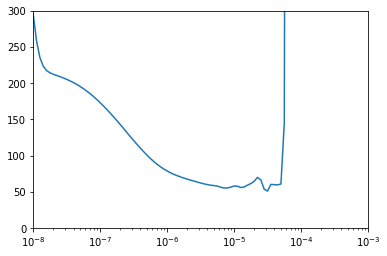

In [18]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [19]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"), 
    tf.keras.layers.Dense(10, activation = "relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr = 8e-6, momentum = 0.9)
model.compile(loss = "mse", optimizer = optimizer)
history = model.fit(dataset, epochs = 500, verbose = 0)

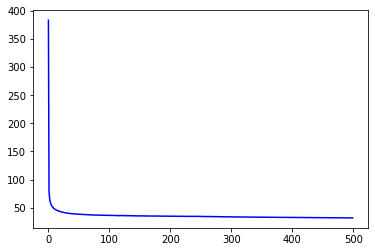

In [20]:
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label = "Training Loss")
plt.show()

[47.860838612821915, 47.16545832132556, 46.46201062546563, 45.88287957968171, 45.39392666374285, 44.88386398787351, 44.50411080822502, 44.089603927454995, 43.83996952489479, 43.372679838200206, 43.048572980743096, 42.770845318823746, 42.40506810453749, 42.08058449263425, 41.80910907627381, 41.66032435230373, 41.330276245431804, 41.22127403180624, 40.90845979513581, 40.913894236456485, 40.521148913668604, 40.34631157707922, 40.318143832806456, 40.13009580631846, 40.119075948184296, 39.81548389552795, 39.69055859673883, 39.57358443663292, 39.55768117216444, 39.40781541804677, 39.267705449369764, 39.21173179862426, 39.081123182945646, 38.958347383479484, 38.885240153676456, 38.83413293582877, 38.76673269370168, 38.62001737221, 38.517737300125596, 38.45102586254631, 38.35451733697321, 38.312461813700565, 38.247110669637465, 38.143361069984046, 38.08358206601487, 38.011609728311754, 37.92219781777293, 37.868494132130415, 37.78575687998349, 37.76194730149102, 37.680005858116544, 37.627431684

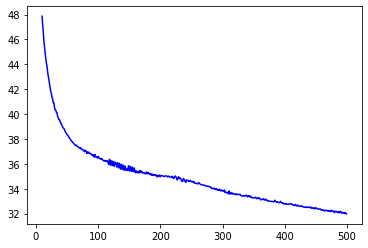

In [21]:
# Plot all but the first 10
loss = history.history["loss"]
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, "b", label = "Training Loss")
plt.show()

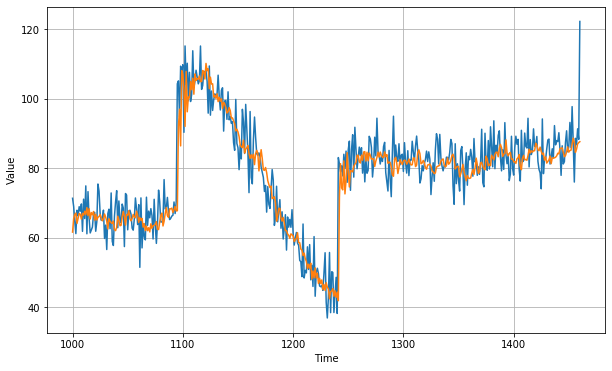

In [22]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.7254586